# Overdensity finder
This code generates the overdensity inside a spherical region. 
This uses the particle density grid created using the ['DensityGridder'](https://github.com/christopherlovell/DensityGridder), also available here: */cosma/home/dp004/dc-love2/DensityGridder*.  We use a $1200^3$ grid on snapshot 2 (z ~ 4.72).

The weights file used is here: /cosma5/data/dp004/dc-payy1/densitygrid/weights_002_1000.bin

Next, we use this grid  to generate the density to select our regions for resimulation.

In [1]:
import numpy as np
import pandas as pd
import gc
from astropy.cosmology import Planck13 as cosmo
import astropy.units as u
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib nbagg

In [2]:
h = 0.6777
pmass = (5.43)*1e10*u.Msun #(in h^-1 units)
uni_dens = cosmo.critical_density(4.72)
uni_dens = uni_dens.to(u.Msun/u.Mpc**3) *(h**2)

In [3]:
boxsize = 3200*h
r = np.array([10., 15., 20.])
grid = 1200
conv = (boxsize/grid)

In [4]:
griddata = np.fromfile("../densitygrid/out_"+str(grid)+".bin", sep='\n')
griddata = np.reshape(griddata, (grid,grid,grid), 'F')
gc.collect()

16

In [5]:
# tot_pts = np.sum(griddata)
# rho_box = tot_pts/(2168.64**3)
vol = (4./3.)*np.pi*(r)**3

In [6]:
def kernel(r):
    
    """
    Defines the kernel needed for a given radius
    """
    
    sz = int(r/conv)
    length = 2*sz+4
    ker = np.zeros((length,length,length))
    sel = np.arange(0, length)
    x, y, z = (length)/2., (length)/2., (length)/2.
    #print x,y,z, sel
    for i in sel:
        for j in sel:
            for k in sel:
                if (i-x)**2+(j-y)**2+(k-z)**2<=(r/conv)**2:
                    ker[i,j,k] = 1.
                
    return ker

In [7]:
def create_3d(kern):
    
    """
    Create a 3d image of the kernel being used
    """
    
    kernal = kern
    empty = np.array([[0,0,0]])
    sz = np.arange(0, len(kernal))
    for i in sz:
        for j in sz:
            for k in sz:
                if kernal[i,j,k] == 1:
                    empty=np.append(empty, np.array([[i,j,k]]), axis = 0)
    empty = empty[1:]
   
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca(projection='3d')
    ax.scatter(empty[:,0], empty[:,1], empty[:,2])
    return ax
    

In [8]:
def near_coords(pos, r):
    
    """
    Gives the coordinates of the points near to the given point inside a a given radius
    coords: in terms of the simuation box coordinates
    pos_coords: array position
    """
    
    a, b, c = pos
    pos_coords = []
    sz = int(max(r)/conv)+1
    
    x = np.arange(a-sz, a+sz+1)
    y = np.arange(b-sz, b+sz+1)
    z = np.arange(c-sz, c+sz+1)
    
    x[x < 0] += grid
    y[y < 0] += grid
    z[z < 0] += grid
    
    x[x >= grid] -= grid
    y[y >= grid] -= grid
    z[z >= grid] -= grid
    
    for i in x: 
        for j in y:
            for k in z:
                pos_coords.append([i, j, k])
    
    pos_coords = np.array(pos_coords)
    
    coords = pos_coords.astype(float)*conv 
    
    return coords, pos_coords

In [9]:
def get_coords(pos):
    
    """
    Given the position of on the density grid it just gives the coordinates in terms of the simualation box
    """
    
    x, y, z = pos
      
    coords = np.zeros((len(x),3))
    
    coords[:,0] = x.astype(float)*conv 
    coords[:,1] = y.astype(float)*conv 
    coords[:,2] = z.astype(float)*conv 
    
    return coords

In [10]:
use = kernel(r[0])

<IPython.core.display.Javascript object>


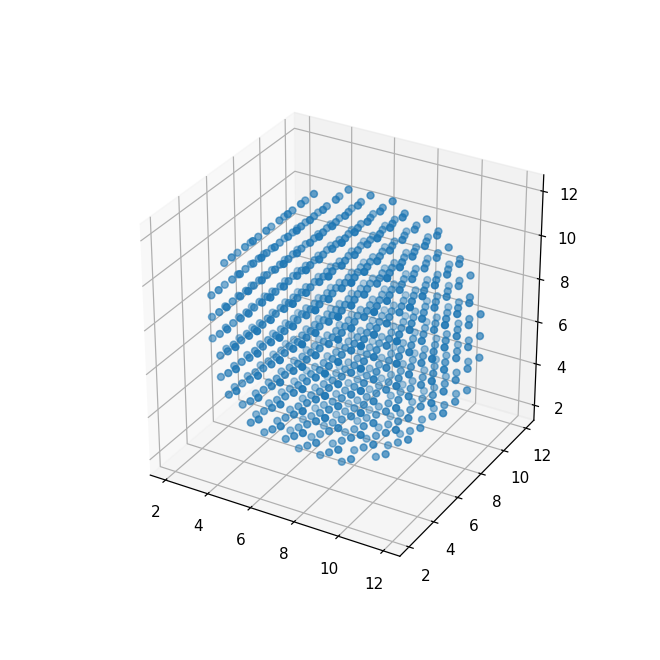

90

In [11]:
create_3d(use)
gc.collect()

In [12]:
numpts = ndimage.convolve(griddata, use, mode='wrap')/vol[0]
delta10 = numpts/np.mean(numpts) - 1.
gc.collect()

15

<IPython.core.display.Javascript object>


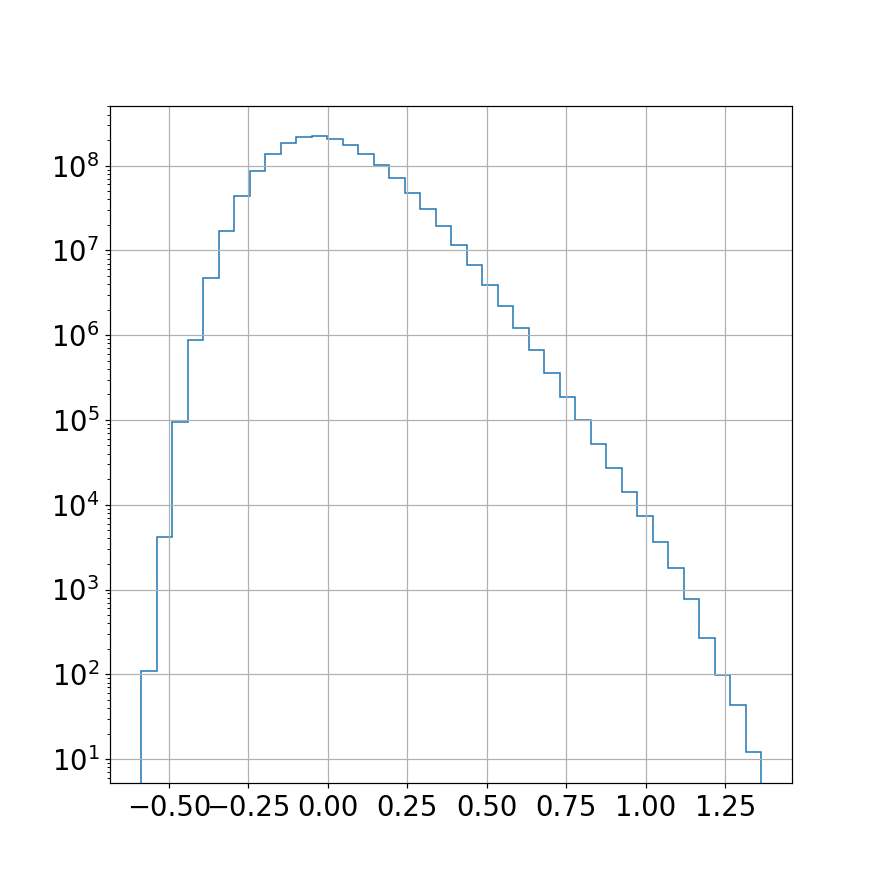

No handlers could be found for logger "matplotlib.legend"


In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(8,8), sharex=False, sharey=False, facecolor='w', edgecolor='k')
#axs.hist(delta10.flatten(), bins = 40, histtype='step', cumulative=True, label='Cumulative')
axs.hist(delta10.flatten(), bins = 40, histtype='step')
axs.set_yscale('log')
axs.grid(True)
axs.legend(loc='upper left', fontsize = 18, frameon = False)
for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(18)
plt.show()

In [ ]:
#create_3d(kernel(r[1]))

In [ ]:
#numpts = ndimage.convolve(griddata, kernel(r[1]), mode='wrap')/vol[1]
#delta15 = numpts/(np.mean(numpts)) - 1.

In [ ]:
#fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(8,8), sharex=False, sharey=False, facecolor='w', edgecolor='k')
#axs.hist(delta15.flatten(), bins = 40, histtype='step', cumulative=True, label='Cumulative')
#axs.hist(delta15.flatten(), bins = 40, histtype='step')
#axs.set_yscale('log')
#axs.grid(True)
#axs.legend(loc='upper left', fontsize = 18, frameon = False)
#for label in (axs.get_xticklabels() + axs.get_yticklabels()):
#    label.set_fontsize(18)
#plt.show()

### To get specific coordinates of the density region, get the position and use get_coords  
All coordinates are in h less units. Maybe use view_region.ipynb to see how the region looks like

The underdense regions $\delta \le 0.$

In [ ]:
# dl0 = np.where(delta10<=0.)
# coordsdl0 = get_coords(dl0)

$\delta \ge$ 1.25

In [ ]:
dge125 = np.where(delta10 >= 1.25)
len(dge125)

Highest density regions, $\delta\ge1.3$

In [33]:
tmp = np.where(delta10>=1.2)
tmp_coords = get_coords(tmp)

In [23]:
tmp_coords[:,0], tmp_coords

(array([ 37.9512,  37.9512,  37.9512,  37.9512,  37.9512,  37.9512,
         37.9512,  39.7584,  39.7584,  39.7584,  39.7584,  39.7584,
         39.7584, 842.1552, 842.1552, 843.9624]),
 array([[  37.9512,  666.8568,   45.18  ],
        [  37.9512,  666.8568,   46.9872],
        [  37.9512,  668.664 ,   43.3728],
        [  37.9512,  668.664 ,   45.18  ],
        [  37.9512,  668.664 ,   46.9872],
        [  37.9512,  670.4712,   45.18  ],
        [  37.9512,  670.4712,   46.9872],
        [  39.7584,  666.8568,   45.18  ],
        [  39.7584,  666.8568,   46.9872],
        [  39.7584,  668.664 ,   45.18  ],
        [  39.7584,  668.664 ,   46.9872],
        [  39.7584,  670.4712,   45.18  ],
        [  39.7584,  670.4712,   46.9872],
        [ 842.1552, 1442.1456, 1062.6336],
        [ 842.1552, 1443.9528, 1062.6336],
        [ 843.9624, 1443.9528, 1062.6336]]))

In [36]:
above12 = pd.DataFrame({'delta': delta10[tmp], 'x': tmp_coords[:,0], 'y': tmp_coords[:,1], 'z': tmp_coords[:,2]}, index = range(len(tmp_coords)))
above12 = above12.sort_values(by=['delta'], ascending=False).reset_index(drop=True)

In [37]:
above12

,delta,x,y,z
0,1.362403,37.9512,668.6640,45.1800
1,1.358896,37.9512,668.6640,46.9872
2,1.353052,39.7584,668.6640,45.1800
3,1.351590,39.7584,668.6640,46.9872
4,1.327773,39.7584,666.8568,45.1800
5,1.327627,37.9512,666.8568,46.9872
6,1.323974,39.7584,670.4712,45.1800
7,1.315938,37.9512,666.8568,45.1800
8,1.315792,843.9624,1443.9528,1062.6336
9,1.315354,37.9512,670.4712,45.1800


In [130]:
selected = pd.DataFrame({'delta': above12['delta'].ix[0], 'x': above12['x'].ix[0], 'y': above12['y'].ix[0], 'z': above12['z'].ix[0]}, index = [0])

In [131]:
for i in range(len(above12)-1):
    
    this = np.array(above12.ix[i+1])[1:]
    
    if np.isscalar(selected['x']):
        tmp = np.array(selected)[1:]
        sep = np.sum((this-tmp)**2)**0.5
    
    else:
        tmp = np.array(selected)[:,1:]
        this = np.array(above12.ix[i+1])[1:]
        sep = np.sum((this-tmp)**2, axis = 1)**0.5
    
    if np.min(sep) > 10:
        #print np.min(sep)
        selected = selected.append(above12.ix[i+1])
        
selected = selected.reset_index(drop=True)

In [102]:
tmp, this

(array([ 37.9512, 668.664 ,  45.18  ]),
 array([1012.032 , 1516.2408, 1451.1816]))

In [132]:
selected

,delta,x,y,z
0,1.362403,37.9512,668.6640,45.1800
1,1.315792,843.9624,1443.9528,1062.6336
2,1.299865,802.3968,1337.3280,1086.1272
3,1.287445,618.0624,1140.3432,1525.2768
4,1.254862,1604.7936,1584.9144,1570.4568
5,1.243903,151.8048,1762.0200,534.9312
6,1.231921,459.0288,1212.6312,1409.6160
7,1.230606,59.6376,885.5280,2099.9664
8,1.221547,1049.9832,1785.5136,800.5896
9,1.218040,852.9984,397.5840,2130.6888
